# Bayesian Neural Network (VI) for classification (under Development)

```
# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#   Licensed under the Apache License, Version 2.0 (the "License").
#   You may not use this file except in compliance with the License.
#   A copy of the License is located at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   or in the "license" file accompanying this file. This file is distributed
#   on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#   express or implied. See the License for the specific language governing
#   permissions and limitations under the License.
# ==============================================================================
```

In [1]:
import warnings
warnings.filterwarnings('ignore')
import mxfusion as mf
import mxnet as mx
import numpy as np
import mxnet.gluon.nn as nn
import mxfusion.components
import mxfusion.inference

### Generate Synthetic Data

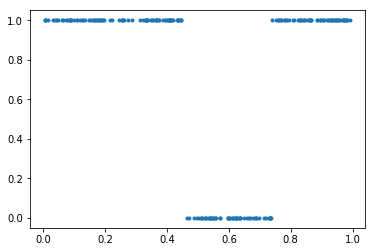

In [2]:
import GPy
%matplotlib inline
from pylab import *

np.random.seed(4)
k = GPy.kern.RBF(1, lengthscale=0.1)
x = np.random.rand(200,1)
y = np.random.multivariate_normal(mean=np.zeros((200,)), cov=k.K(x), size=(1,)).T>0.
plot(x[:,0], y[:,0], '.')

In [3]:
D = 10
net = nn.HybridSequential(prefix='nn_')
with net.name_scope():
    net.add(nn.Dense(D, activation="tanh", flatten=False, in_units=1))
    net.add(nn.Dense(D, activation="tanh", flatten=False, in_units=D))
    net.add(nn.Dense(2, flatten=False, in_units=D))
net.initialize(mx.init.Xavier(magnitude=1))

In [4]:
from mxfusion.components.variables.var_trans import PositiveTransformation
from mxfusion.inference import VariationalPosteriorForwardSampling
from mxfusion.components.functions.operators import broadcast_to
from mxfusion.components.distributions import Normal, Categorical
from mxfusion import Variable, Model
from mxfusion.components.functions import MXFusionGluonFunction

In [5]:
m = Model()
m.N = Variable()
m.f = MXFusionGluonFunction(net, num_outputs=1, broadcastable=False)
m.x = Variable(shape=(m.N,1))
m.r = m.f(m.x)
for _,v in m.r.factor.parameters.items():
    v.set_prior(Normal(mean=broadcast_to(mx.nd.array([0]), v.shape),
                       variance=broadcast_to(mx.nd.array([1.]), v.shape)))
m.y = Categorical.define_variable(log_prob=m.r, shape=(m.N,1), num_classes=2)
print(m)

Model (cf188)
Variable(ca45c) = BroadcastToOperator(data=Variable(8dec8))
Variable(383ef) = BroadcastToOperator(data=Variable(faf0a))
Variable(44754) ~ Normal(mean=Variable(383ef), variance=Variable(ca45c))
Variable(03371) = BroadcastToOperator(data=Variable(ad532))
Variable(88468) = BroadcastToOperator(data=Variable(2110c))
Variable(84fc2) ~ Normal(mean=Variable(88468), variance=Variable(03371))
Variable(1dc39) = BroadcastToOperator(data=Variable(f3d0f))
Variable(77d1c) = BroadcastToOperator(data=Variable(121a5))
Variable(4e7d9) ~ Normal(mean=Variable(77d1c), variance=Variable(1dc39))
Variable(dbd5d) = BroadcastToOperator(data=Variable(68ad8))
Variable(51f11) = BroadcastToOperator(data=Variable(1ac45))
Variable(dccd6) ~ Normal(mean=Variable(51f11), variance=Variable(dbd5d))
Variable(47fa5) = BroadcastToOperator(data=Variable(e966f))
Variable(90359) = BroadcastToOperator(data=Variable(f19f8))
Variable(daaa7) ~ Normal(mean=Variable(90359), variance=Variable(47fa5))
Variable(c310f) = Bro

In [6]:
from mxfusion.inference import BatchInferenceLoop, create_Gaussian_meanfield, GradBasedInference, StochasticVariationalInference, MAP

In [7]:
observed = [m.y, m.x]
q = create_Gaussian_meanfield(model=m, observed=observed)
alg = StochasticVariationalInference(num_samples=5, model=m, posterior=q, observed=observed)
infr = GradBasedInference(inference_algorithm=alg, grad_loop=BatchInferenceLoop())

In [8]:
infr.initialize(y=mx.nd.array(y), x=mx.nd.array(x))

In [9]:
for v_name, v in m.r.factor.parameters.items():
    infr.params[q[v].factor.mean] = net.collect_params()[v_name].data()
    infr.params[q[v].factor.variance] = mx.nd.ones_like(infr.params[q[v].factor.variance])*1e-6

In [10]:
infr.run(max_iter=500, learning_rate=1e-1, y=mx.nd.array(y), x=mx.nd.array(x), verbose=True)

Iteration 51 loss: 661.41601562593755
Iteration 101 loss: 301.83178710937525
Iteration 151 loss: 166.81152343757812
Iteration 201 loss: 159.75297546386725
Iteration 251 loss: 154.61776733398438
Iteration 301 loss: 147.10989379882812
Iteration 351 loss: 153.09896850585938
Iteration 401 loss: 131.58213806152344
Iteration 451 loss: 147.08862304687556
Iteration 500 loss: 136.80494689941406

In [11]:
# for uuid, v in infr.inference_algorithm.posterior.variables.items():
#     if uuid in infr.params.param_dict:
#         print(v.name, infr.params[v])

In [12]:
xt = np.linspace(0,1,100)[:,None]

In [13]:
infr2 = VariationalPosteriorForwardSampling(10, [m.x], infr, [m.r])
res = infr2.run(x=mx.nd.array(xt))

In [14]:
yt = res[0].asnumpy()

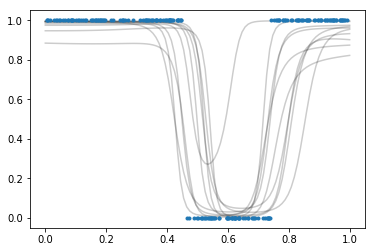

In [15]:
yt_mean = yt.mean(0)
yt_std = yt.std(0)
for i in range(yt.shape[0]):
    plot(xt[:,0],1./(1+np.exp(yt[i,:,0]-yt[i,:,1])),'k',alpha=0.2)
plot(x[:,0],y[:,0],'.')